# Tiefenabhängigkeit der Partialwellenamplituden

In [1]:
using Plots
default(framestyle=:box, widen=true)
using LaTeXStrings
using Latexify
using Printf

ArgumentError: ArgumentError: Package Plots not found in current path:
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.


In [2]:
logspace(from, to, len) = exp10.(range(from, stop=to, length=len))
linspace(from, to, len) = range(from, stop=to, length=len)

linspace (generic function with 1 method)

Wir betrachten vorerst nur ebene Wellen, setzen also $\lambda = 0$.

In [3]:
λ = 0
freq = 10.0
ω = 2 * pi * freq
μ₀ = pi * 4e-7;

Die elektrische Leitfähigkeit besitzt bis zur halben Skintiefe, d.h. im Tiefenintervall $0 \le z < 0.5 \,p_1$  den Wert $\sigma(z) = \sigma_1 = 0.01$ S/m.
In der Tiefe $z = 0.5\,p_1$ springt die Leitfähigkeit auf ihren zehnfachen Wert, d.h., $\sigma(z) = \sigma_2 = 10 \, \sigma_1$ für $0.5\,p_1 \le z < \infty$.

Die elektromagnetische Eindringtiefe beträgt in der ersten Schicht

\begin{equation}
p_1 = \sqrt{ \frac{2}{\omega\mu\sigma_1} } \approx \frac{503}{\sqrt{f\,\sigma_1}}.
\end{equation}

In [4]:
σ₁ = 1e-2
p₁ = 503 / sqrt(σ₁ * freq)
z₁ = 0.5 * p₁
@printf("Die elektromagnetische Eindringtiefe in der Schicht 1 beträgt %.0f m.", p₁)

LoadError: UndefVarError: @printf not defined

Wir untersuchen den Einfluss der magnetischen Permeabilität, indem wir in jeder Schicht auch $\mu_r \ne 1$ zulassen.

In unserem Beispiel springt $\mu(z)$ in der Tiefe $z = 0.5 \, p_1$ ebenfalls.

In [5]:
h = linspace(0.0, 2.0 * p₁, 101)
h = sort(vcat(h, z₁))
nl = length(h)
d = diff(h)
ib = findfirst(h .> z₁)
σ = σ₁ * ones(nl)
μ = μ₀ * ones(nl)
σ[ib-1:nl] .= 10.0 * σ₁
μ[ib-1:nl] .= 10.0 * μ₀;

## Rekursionsalgorithmus zur Berechnung der Oberflächenadmittanz

Für jede der $N$ Schichten definieren wir einen komplexen Dämpfungsparameter $\alpha_n = \sqrt{\lambda^2 + i \omega \mu_n \sigma_n}$ sowie $\eta_n = \alpha_n / \mu_n$, $1 \le n \le N$.

Außerdem ist $B_n := B(h_n) = -\dfrac{V'(h_n)}{V(h_n)}$ die Admittanz an der Oberkante der $n$-ten Schicht.

Für das Substratum (das ist die nach unten unbegrenzte Schicht) folgt speziell

$$
B_N = \eta_N,
$$

und ein Rekursionsalgorithmus der Form $B_{n+1} \mapsto B_n$ liefert schließlich die Oberflächenadmittanz $B_1$ in $z=h_1=0$:

\begin{equation}
B_{n}=\eta_{n} \frac{B_{n+1}+\eta_{n} \tanh \left(\alpha_{n} d_{n}\right)}{\eta_{n}+B_{n+1} \tanh \left(\alpha_{n} d_{n}\right)}, \quad n=N-1, \ldots, 1
\end{equation}

Die Fortsetzung der Partialwellenamplituden von $z=0$ in die Tiefe liefert Ausdrücke für $V(z)/V(0)$ und $V'(z)/V'(0)$.

Wir benutzen hier nur die Fortsetzung von Schichtgrenze zu Schichtgrenze, wobei

$$
V(h_{n+1}) = e^{-\alpha_n d_n} \frac{\eta_n + B_n}{\eta_n + B_{n+1}} \, V(h_n) 
$$
und
$$
V'(h_{n+1}) = e^{-\alpha_n d_n} \frac{1 + \eta_n / B_n}{1 + \eta_n /B_{n+1}} \, V'(h_n) .
$$
Zusätzlich seien $V(0) = 1$ und $V'(0) = 1$.

In [6]:
function admittance(λ, σ, μ, d, f)
    nl = length(σ)
    ω = 2 * pi * f
    α = zeros(Complex{Float64}, nl)
    η = zeros(Complex{Float64}, nl)
    α .= sqrt.(λ^2 .+ im .* μ .* ω .* σ)
    η = α ./ μ
    
    B = zeros(Complex{Float64}, nl)
    V = zeros(Complex{Float64}, nl)
    Vp = similar(V)
    V[1] = one(Complex{Float64})
    Vp[1] = one(Complex{Float64})
    
    tanh(z) = (1 - exp(-2*x)) / (1 + exp(-2*x))
    B[nl] = η[nl]
    for n = nl-1:-1:1
        B[n] = η[n] * 
                    (B[n+1] + η[n] * tanh(α[n] * d[n])) /
                    (η[n] + B[n+1] * tanh(α[n] * d[n]))
    end
    
    for n = 2:nl
        V[n] = V[n-1] * exp(-α[n-1] * d[n-1]) * 
                (η[n-1] + B[n-1]) / 
                (η[n-1] + B[n])
        Vp[n] = Vp[n-1] * exp(-α[n-1] * d[n-1]) * 
                (1.0 + η[n-1] / B[n-1]) / 
                (1.0 + η[n-1] / B[n])
    end
    
    return B, V, Vp
end

admittance (generic function with 1 method)

In [7]:
B, V, Vp = admittance(λ, σ, μ, d, freq);

UndefVarError: UndefVarError: x not defined

Die Impedanz lässt sich aus der Admittanz nach der Gleichung

$$
Z_n = \frac{i\omega}{B_n}
$$

berechnen.

Daraus kann man die z.B. in der Magnetotellurik übliche Darstellungsgröße *scheinbarer spezifischer Widerstand* ermitteln:

$$
    \rho_a = \frac{1}{\omega\mu_0}\bigl|Z\bigl|^2
$$

Wir erhalten das überraschende Resultat $\rho_a = 100~\Omega\cdot m$, falls $\mu$ in der selben Tiefe mit dem selben Verhältnis springt wie $\sigma$.

In [197]:
Z = im * ω ./ B;

@printf("rhoa = %.0f Ohm*m", abs(Z[1])^2 / ω / μ₀)

rhoa = 100 Ohm*m

## Visualisierung des Feldverlaufes

Aus dem Potential $F(r, z)$ werden die Felder über Ableitungen nach $z$ und $r$ erhalten.

* Welche Feldkomponente wird aus der Ableitung nach $r$ berechnet?
* Welche Feldkomponente wird aus der Ableitung nach $z$ berechnet?
* Ordnen Sie die entsprechende Komponente $V(z)$ bzw. $V'(z)$ zu.


#### Verlauf von $V(z)$

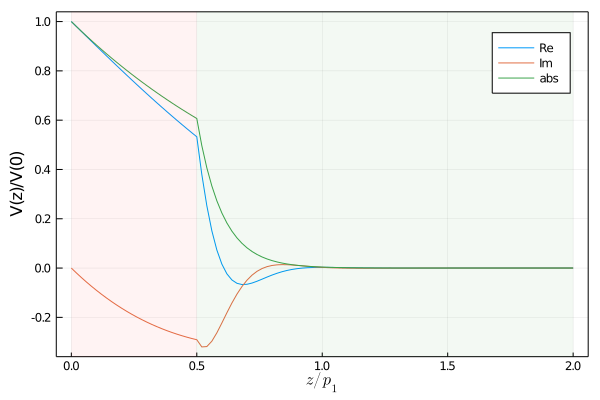

In [182]:
h_norm = h ./ p₁
plot(h_norm, real(V), label="Re")
plot!(h_norm, imag(V), label="Im")
plot!(h_norm, abs.(V), label="abs", xlabel=L"z / p_1", ylabel="V(z)/V(0)")

plot!([0, 0.5], label="", 
    opacity=0.05, color="red", seriestype=:vspan)
plot!([0.5, 2], label="", 
    opacity=0.05, color="green", seriestype=:vspan)

#### Verlauf von $V'(z)$

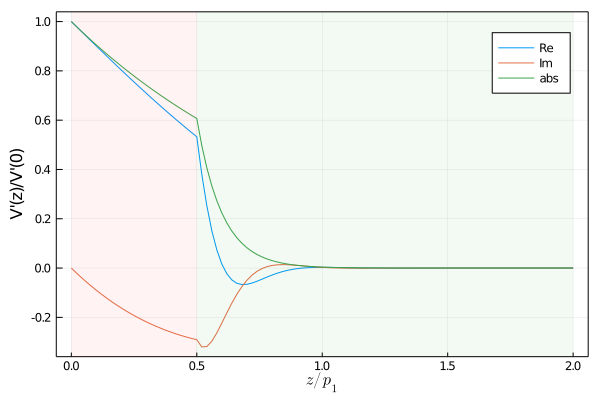

In [183]:
plot(h_norm, real(Vp), label="Re")
plot!(h_norm, imag(Vp), label="Im")
plot!(h_norm, abs.(Vp), label="abs", xlabel=L"z / p_1", ylabel="V'(z)/V'(0)")

plot!([0, 0.5], label="", 
    opacity=0.05, color="red", seriestype=:vspan)
plot!([0.5, 2], label="", 
    opacity=0.05, color="green", seriestype=:vspan)

Wie kommt der Knick im elektrischen Feld zustande, wenn $\mu(z)$ springt?

Die Antwort geben wie immer die Maxwellschen Gleichungen.

Wir beobachten den Knick an der Schichtgrenze.

Knick bedeutet, dass die Ableitung nach $z$ springt.

Welche Größe kann durch die $z$-Ableitung von $V(z)$ dargestellt werden?

Der Knick in $V'(z)$ tritt auch auf, wenn $\mu(z)$ konstant ist. Warum?

## Sondierungskurve für den Zweischichtfall

Für logarithmisch äquidistant gelegene Periodendauern soll eine Sondierungskurve $\rho_a(T)$ gezeichnet werden (Periodendauer $T = 1 / f$).

Wir wählen $10^{-2} \le T \le 10^2$ Sekunden und berechnen daraus $\rho_a$ für den oben vereinbarten Zweischcihtfall mit $\sigma=\sigma(z)$ und $\mu=\mu(z)$.

Da nur $\lambda=0$ betrachtet wird, erhalten wir eine Sondierungskurve der Magnetotellurik.

Bei homogener Anregung (vertikal einfallende ebene Welle; "unendlich ausgedehnte Lichtquelle mit parallelen Lichtstrahlen") ist die Wellenzahl (hier $\lambda$) gleich Null.

In [184]:
T = logspace(-2, 2, 41)
rhoa = zeros(length(T), 1)
for k in 1:length(T)
    ω = 2 * pi / T[k]
    B1,_,_ = admittance(λ, σ, μ, d, 1 / T[k])
    Z1 = im * ω / B1[1]
    rhoa[k] = abs(Z1)^2 / ω / μ₀
end

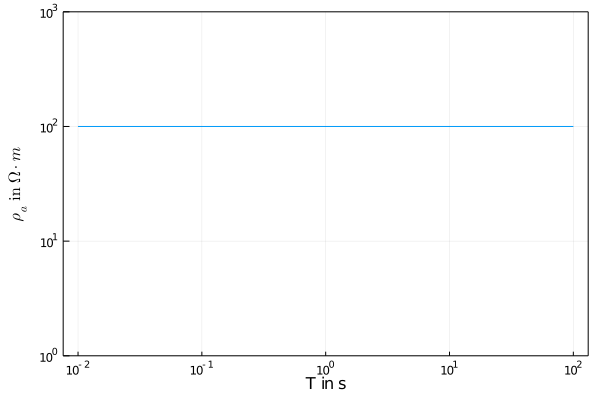

In [185]:
plot(T, rhoa, xaxis=:log, yaxis=:log, label="", xlabel="T in s", 
    ylabel=L"\rho_a \mathrm{~in~}\Omega\cdot m")
ylims!((1e0, 1e3))

## Beobachtung

Die magnetische Permeabilität $\mu_r > 1$ wird sich im homogen leitfähigen Halbraum wie eine Schicht mit hohem spezifischen Widerstand aus.